In [1]:
from pyspark import SparkConf, SparkContext

conf = SparkConf()
conf.setAll([
    ("spark.executor.instances", 3)
])
sc = SparkContext(
    master="yarn",
    appName="web-archive-query-log-query-length",
    conf=conf,
)
sc

<SparkContext master=yarn appName=web-archive-query-log-query-length>

In [100]:
from pathlib import Path

# TODO: For final evaluation, use the full corpus.
# corpus_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/corpus/")
corpus_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/sample-corpus/")
queries_dir = corpus_dir / "queries"

In [101]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [102]:
from json import loads
from pandas import DataFrame

counts = sc.textFile(f"file://{queries_dir}")\
    .map(lambda line: loads(line))\
    .filter(lambda query: query["url_query"] is not None) \
    .keyBy(lambda query: (
        len(query["url_query"]),
        query["service"],
    ))\
    .countByKey()

In [103]:
from numpy import percentile

df = DataFrame([
    {
        "url_query_length": url_query_length,
        "service": service,
        "count": count,
    }
    for (url_query_length, service), count in counts.items()
])
df = df[df["url_query_length"] <= percentile(df["url_query_length"], 90)]
total_count = df["count"].sum()
services = sorted(
    df["service"].unique(),
    key=lambda service: df[df["service"] == service]["count"].sum(),
    reverse=True,
)[:5]
df = df[df["service"].isin(services)]
df

,url_query_length,service,count
0,14,baidu,17639
1,13,baidu,200
2,31,google,670
3,41,google,282
4,26,google,1009
...,...,...,...
5728,90,twitter,1
5781,54,stackoverflow,2
5875,101,twitter,1
5897,78,baidu,1


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


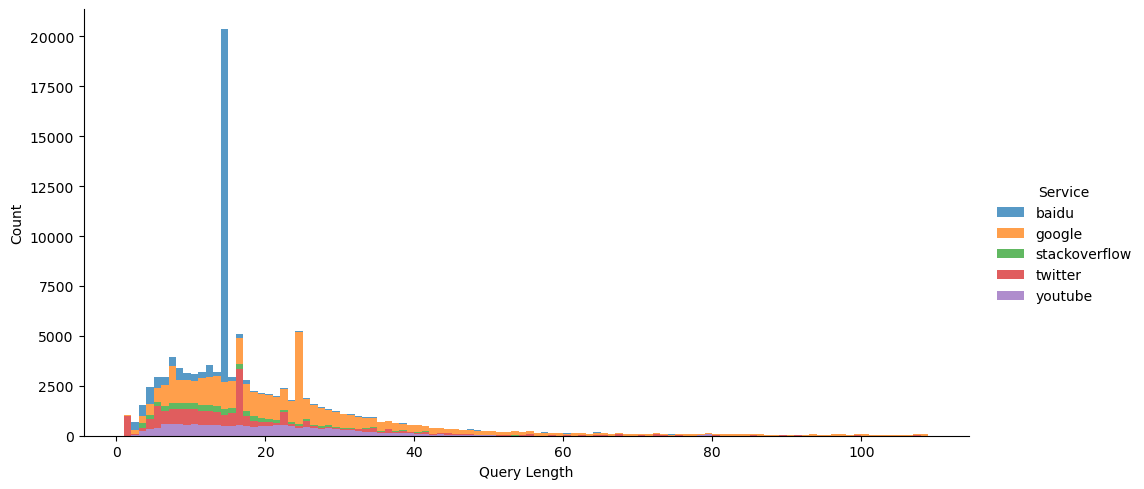

In [130]:
from seaborn import displot

plot = displot(
    data=df.rename(columns={
        "url_query_length": "Query Length",
        "count": "Count",
        "service": "Service",
    }),
    x="Query Length",
    weights="Count",
    hue="Service",
    binwidth=1,
    multiple="stack",
    aspect=2,
    linewidth=0,
)
plot.set_axis_labels("Query Length", "Count")
plot.savefig(figures_dir / "query-length-histogram.pdf")
plot.savefig(figures_dir / "query-length-histogram.png")
plot

In [108]:
from numpy import percentile

df2 = df.copy()
df2["count"] = df2["count"].clip(upper=percentile(df["count"], 99))
df2

,url_query_length,service,count
0,14,baidu,1490.75
1,13,baidu,200.00
2,31,google,670.00
3,41,google,282.00
4,26,google,1009.00
...,...,...,...
5728,90,twitter,1.00
5781,54,stackoverflow,2.00
5875,101,twitter,1.00
5897,78,baidu,1.00


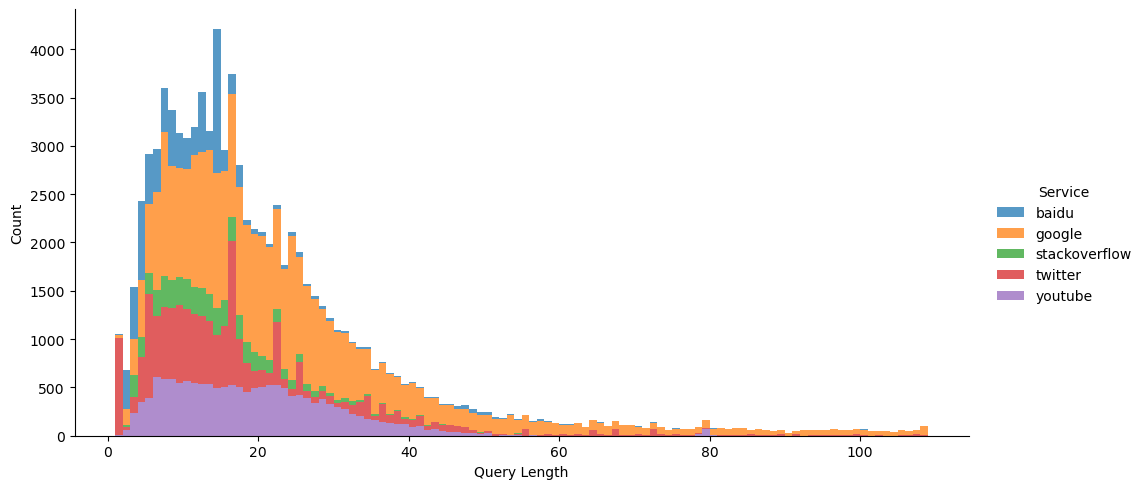

In [129]:
from seaborn import displot

plot = displot(
    data=df2.rename(columns={
        "url_query_length": "Query Length",
        "count": "Count",
        "service": "Service",
    }),
    x="Query Length",
    weights="Count",
    hue="Service",
    binwidth=1,
    multiple="stack",
    aspect=2,
    linewidth=0,
)
plot.savefig(figures_dir / "query-length-histogram-without-outliers.pdf")
plot.savefig(figures_dir / "query-length-histogram-without-outliers.png")
plot